2D Poisson equation:
$$u_{xx} + u_{yy} = f(x, y)$$
where 
$$f(x, y) = -8\pi^2 \sin(2\pi x) \sin(2\pi y)$$

Over the domain $\Omega = [0, 1] \times [0, 1]$, with mixed boundary conditions:
$$u(x, 0) = 0$$
$$u(0, y) = u(1, y)$$
$$\frac{\partial u}{\partial n}(x, 1) = 2\pi \sin(2\pi x)$$

The solution we're aiming for is $$u(x, y) = \sin(2\pi x) \sin(2\pi y)$$.

In [52]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io
from scipy.stats import qmc

from tqdm import tqdm

In [53]:
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
device

device(type='mps')

In [54]:
def plot3D_Matrix(x, y, u):
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(x, y, u ,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('u(x,y)')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()

  
  ax = plt.axes(projection='3d')
  ax.plot_surface(x, y, u,cmap="rainbow")
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('u(x,y)')
  plt.show()

In [55]:
def plot3D_error(x, y, u):
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(x, y, u ,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('error')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()

  
  ax = plt.axes(projection='3d')
  ax.plot_surface(x, y, u,cmap="rainbow")
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('error')
  plt.show()

In [56]:
def f_real(x, y):
    return torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)

In [57]:
steps = 40000
lr = 0.00001
layers = np.array([2, 128, 256, 256, 256, 256, 256,256, 128, 1])

x_min = 0
x_max = 1
y_min = 0
y_max = 1

total_points_x = 1000
total_points_y = 1000

N_boundary = 4 # number of boundaries
N_u_boundary = 10000 # number of points on each boundary
N_u = N_boundary * N_u_boundary
N_f = 10000 # number of collocation points

w_bc_top = 10
w_bc_bottom = 1
w_bc_lr = 1

gamma = 1

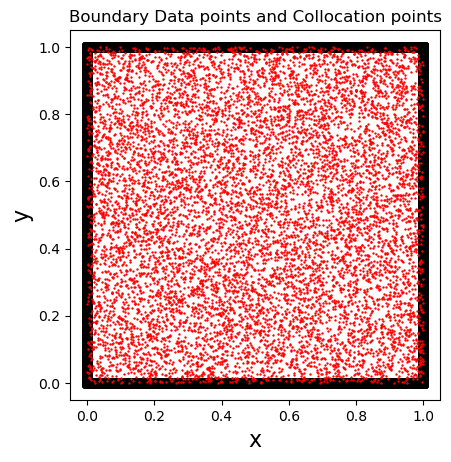

In [58]:
engine = qmc.LatinHypercube(d=1)

boundary_top = engine.random(n = N_u_boundary)
boundary_lr = engine.random(n = N_u_boundary)
boundary_bot = engine.random(n = N_u_boundary)

data = np.zeros([N_boundary, N_u_boundary, 2])

data[0, :, 0] = boundary_top[:, 0]
data[1, :, 1] = boundary_lr[:, 0]
data[2, :, 1] = boundary_lr[:, 0]
data[3, :, 0] = boundary_bot[:, 0]

data[0, :, 1] = np.ones(N_u_boundary) # y = 1
data[1, :, 0] = np.zeros(N_u_boundary) # x = 0
data[2, :, 0] = np.ones(N_u_boundary) # x = 1
data[3, :, 1] = np.zeros(N_u_boundary) # y = 0

data = data.reshape(-1, 2)
x_d, y_d = data[:, 0:1], data[:, 1:2]

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n = N_f)

x_f, y_f = colloc[:, 0:1], colloc[:, 1:2]

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()

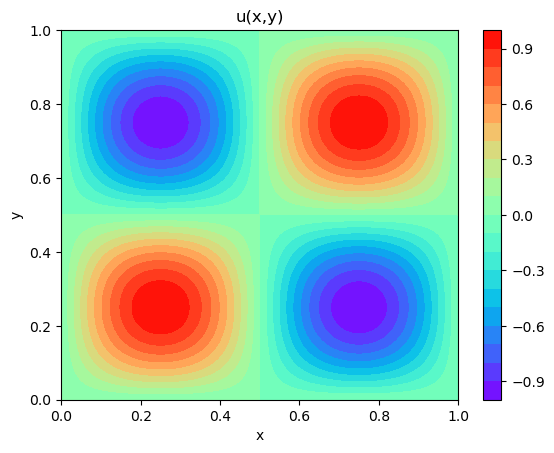

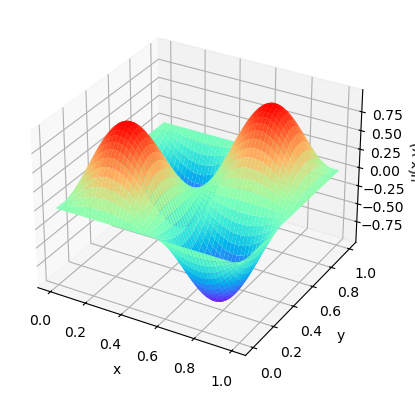

In [59]:
x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)
U_real = f_real(X, Y)

plot3D_Matrix(X, Y, U_real)

In [60]:
# indexing nonsense - I don't know what this means

x_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], Y.transpose(1, 0).flatten()[:, None]))
u_test = U_real.transpose(1, 0).flatten()[:, None]

x_test = x_test.float().to(device)
u_test = u_test.float().to(device)

train_bd_top = torch.tensor(boundary_top).float().to(device)
train_bd_lr = torch.tensor(boundary_lr).float().to(device)
train_bd_bot = torch.tensor(boundary_bot).float().to(device)

x_train_colloc = torch.tensor(x_f).float().to(device)
y_train_colloc = torch.tensor(y_f).float().to(device)



In [61]:
class PINN(nn.Module):

    def __init__(self, layers):
        super().__init__()
        
        #self.activation = nn.Sigmoid()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y)
        
        a = torch.cat((x.float(), y.float()), axis=1)

        
        # ugly way to make last layer linear
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    # Neumann BC on top
    def loss_BC_top(self, x):
        x_clone = x.clone().requires_grad_(True)
        y = torch.ones_like(x_clone).requires_grad_(True)
        
        u = self.forward(x_clone, y)
        u_y = autograd.grad(u.sum(), y, create_graph=True)[0]
        
        return self.loss_function(u_y, 2 * np.pi * torch.cos(2 * np.pi * x_clone))
    
    # Periodic BC on left/right
    def loss_BC_lr(self, y):
        u_l = self.forward(torch.zeros_like(y), y)
        u_r = self.forward(torch.ones_like(y), y)
        
        return self.loss_function(u_l, u_r)
    
    # Dirichlet BC on bottom
    def loss_BC_bot(self, x):
        return self.loss_function(self.forward(x, torch.zeros_like(x)), torch.zeros_like(x))
    
    def loss_PDE(self, x, y):
        x_clone = x.clone().requires_grad_(True)
        y_clone = y.clone().requires_grad_(True)
        
        u = self.forward(x_clone, y_clone)
        u_x = autograd.grad(u.sum(), x_clone, create_graph=True)[0]
        u_y = autograd.grad(u.sum(), y_clone, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x_clone, create_graph=True)[0]
        u_yy = autograd.grad(u_y.sum(), y_clone, create_graph=True)[0]

        f = u_xx + u_yy
        return self.loss_function(f + 8 * np.pi**2 * torch.sin(2 * np.pi * x_clone) * torch.sin(2 * np.pi * y_clone), torch.zeros_like(f))
    
    def loss (self, x_top, x_bot, y_lr, x_PDE, y_PDE):
        return w_bc_bottom * self.loss_BC_bot(x_bot) + w_bc_lr * self.loss_BC_lr(y_lr) + w_bc_top * self.loss_BC_top(x_top) + self.loss_PDE(x_PDE, y_PDE)

In [62]:
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

In [63]:
start_time = time.time()

train_losses = np.array([])
test_losses = np.array([])

for epoch in tqdm(range(steps)):
    optimizer.zero_grad()
    loss = model.loss(train_bd_top, train_bd_bot, train_bd_lr, x_train_colloc, y_train_colloc)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        with torch.no_grad():
            # Add testing collocation points to make this work better
            test_loss = model.loss_function(model(x_test[:, 0:1], x_test[:, 1:2]), f_real(x_test[:, 0:1], x_test[:, 1:2]))
        train_losses = np.append(train_losses, loss.item())
        test_losses = np.append(test_losses, test_loss.item())
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss.item()}, Test loss {test_loss.item()}')
        
end_time = time.time()
print(f'Training time: {end_time - start_time}s')

  0%|          | 2/40000 [00:03<16:26:15,  1.48s/it]

Epoch 0, Training loss 1754.6136474609375, Test loss 0.27085956931114197


  3%|▎         | 1003/40000 [01:55<1:36:04,  6.77it/s]

Epoch 1000, Training loss 225.99224853515625, Test loss 1.0446606874465942


  5%|▌         | 2003/40000 [03:43<1:33:03,  6.80it/s]

Epoch 2000, Training loss 5.99871826171875, Test loss 0.2332606315612793


  8%|▊         | 3003/40000 [05:35<1:31:52,  6.71it/s]

Epoch 3000, Training loss 0.7394285202026367, Test loss 0.13297967612743378


 10%|█         | 4003/40000 [07:25<1:30:24,  6.64it/s]

Epoch 4000, Training loss 0.4120006859302521, Test loss 0.11616498976945877


 13%|█▎        | 5003/40000 [09:14<1:23:48,  6.96it/s]

Epoch 5000, Training loss 0.26556456089019775, Test loss 0.11735497415065765


 15%|█▌        | 6003/40000 [11:02<1:23:47,  6.76it/s]

Epoch 6000, Training loss 0.17394238710403442, Test loss 0.1277582198381424


 18%|█▊        | 7003/40000 [12:50<1:20:11,  6.86it/s]

Epoch 7000, Training loss 0.11442608386278152, Test loss 0.14517109096050262


 20%|██        | 8003/40000 [14:40<1:19:22,  6.72it/s]

Epoch 8000, Training loss 0.07733362168073654, Test loss 0.16685260832309723


 23%|██▎       | 9003/40000 [16:28<1:15:55,  6.80it/s]

Epoch 9000, Training loss 0.055285580456256866, Test loss 0.18738631904125214


 25%|██▌       | 10003/40000 [18:16<1:13:52,  6.77it/s]

Epoch 10000, Training loss 0.04225941747426987, Test loss 0.20388856530189514


 28%|██▊       | 11003/40000 [20:04<1:10:38,  6.84it/s]

Epoch 11000, Training loss 0.03352846950292587, Test loss 0.21758349239826202


 30%|███       | 12003/40000 [21:52<1:08:49,  6.78it/s]

Epoch 12000, Training loss 0.027026263996958733, Test loss 0.22943420708179474


 33%|███▎      | 13003/40000 [23:41<1:07:06,  6.71it/s]

Epoch 13000, Training loss 0.022298390045762062, Test loss 0.2389127016067505


 35%|███▌      | 14002/40000 [25:30<2:47:22,  2.59it/s]

Epoch 14000, Training loss 0.019342748448252678, Test loss 0.24571844935417175


 38%|███▊      | 15003/40000 [37:38<1:01:50,  6.74it/s]   

Epoch 15000, Training loss 0.016340846195816994, Test loss 0.2530001401901245


 40%|████      | 16003/40000 [39:27<1:02:04,  6.44it/s]

Epoch 16000, Training loss 0.014094050973653793, Test loss 0.2594577670097351


 43%|████▎     | 17003/40000 [41:15<56:33,  6.78it/s]  

Epoch 17000, Training loss 0.012281030416488647, Test loss 0.2655844986438751


 45%|████▌     | 18003/40000 [43:04<53:30,  6.85it/s]  

Epoch 18000, Training loss 0.010580018162727356, Test loss 0.2720387578010559


 48%|████▊     | 19003/40000 [44:52<52:00,  6.73it/s]  

Epoch 19000, Training loss 0.009436210617423058, Test loss 0.27717506885528564


 50%|█████     | 20003/40000 [46:40<48:15,  6.91it/s]  

Epoch 20000, Training loss 0.008367071859538555, Test loss 0.2825751304626465


 53%|█████▎    | 21003/40000 [48:28<47:15,  6.70it/s]  

Epoch 21000, Training loss 0.007718895561993122, Test loss 0.2867169976234436


 55%|█████▌    | 22003/40000 [50:16<44:46,  6.70it/s]  

Epoch 22000, Training loss 0.006812125910073519, Test loss 0.29213017225265503


 58%|█████▊    | 23003/40000 [52:04<41:49,  6.77it/s]

Epoch 23000, Training loss 0.006248146295547485, Test loss 0.2963935434818268


 60%|██████    | 24003/40000 [53:53<39:20,  6.78it/s]

Epoch 24000, Training loss 0.00559837743639946, Test loss 0.30118221044540405


 63%|██████▎   | 25003/40000 [1:12:43<36:14,  6.90it/s]     

Epoch 25000, Training loss 0.0051279934123158455, Test loss 0.3052603602409363


 65%|██████▌   | 26003/40000 [1:14:28<33:18,  7.00it/s]

Epoch 26000, Training loss 0.00468373391777277, Test loss 0.309299111366272


 68%|██████▊   | 27003/40000 [1:32:33<30:56,  7.00it/s]      

Epoch 27000, Training loss 0.004243504721671343, Test loss 0.31370607018470764


 70%|███████   | 28001/40000 [1:35:10<1:37:34,  2.05it/s] 

Epoch 28000, Training loss 0.003956127911806107, Test loss 0.31663569808006287


 73%|███████▎  | 29002/40000 [1:42:16<1:10:40,  2.59it/s]  

Epoch 29000, Training loss 0.0035550782922655344, Test loss 0.32084372639656067


 75%|███████▌  | 30003/40000 [1:56:45<23:37,  7.05it/s]     

Epoch 30000, Training loss 0.0033721968065947294, Test loss 0.32330524921417236


 78%|███████▊  | 31003/40000 [2:00:02<21:27,  6.99it/s]   

Epoch 31000, Training loss 0.003107217373326421, Test loss 0.32642239332199097


 80%|████████  | 32003/40000 [2:03:46<19:09,  6.96it/s]   

Epoch 32000, Training loss 0.0028981799259781837, Test loss 0.32937419414520264


 83%|████████▎ | 33002/40000 [2:13:11<30:16,  3.85it/s]     

Epoch 33000, Training loss 0.00272555323317647, Test loss 0.3317228853702545


 85%|████████▌ | 34003/40000 [2:18:33<14:15,  7.01it/s]    

Epoch 34000, Training loss 7.412675857543945, Test loss 0.3406255543231964


 88%|████████▊ | 35003/40000 [2:26:56<11:51,  7.02it/s]     

Epoch 35000, Training loss 0.0023942040279507637, Test loss 0.33698680996894836


 90%|█████████ | 36003/40000 [2:40:13<09:30,  7.01it/s]     

Epoch 36000, Training loss 0.0022570649161934853, Test loss 0.33904677629470825


 93%|█████████▎| 37002/40000 [2:46:38<19:18,  2.59it/s]   

Epoch 37000, Training loss 0.002134444657713175, Test loss 0.3418070077896118


 95%|█████████▌| 38003/40000 [2:56:36<04:46,  6.97it/s]   

Epoch 38000, Training loss 0.002021005842834711, Test loss 0.34335750341415405


 98%|█████████▊| 39003/40000 [3:02:42<02:21,  7.04it/s]   

Epoch 39000, Training loss 0.0019002100452780724, Test loss 0.3454531729221344


100%|██████████| 40000/40000 [3:19:41<00:00,  3.34it/s]    

Training time: 11981.707648038864s


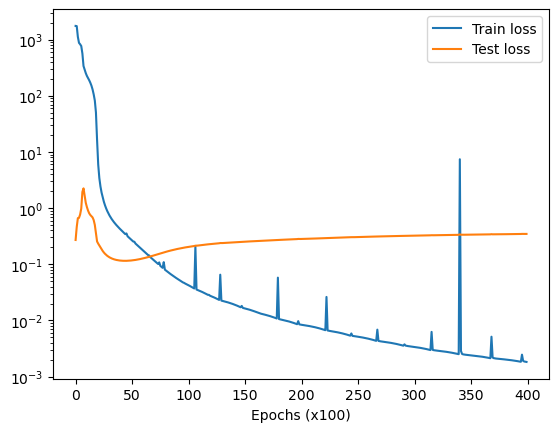

In [64]:
plt.semilogy(train_losses, label='Train loss')
plt.semilogy(test_losses, label='Test loss')
plt.xlabel('Epochs (x100)')
plt.legend()


Plots!

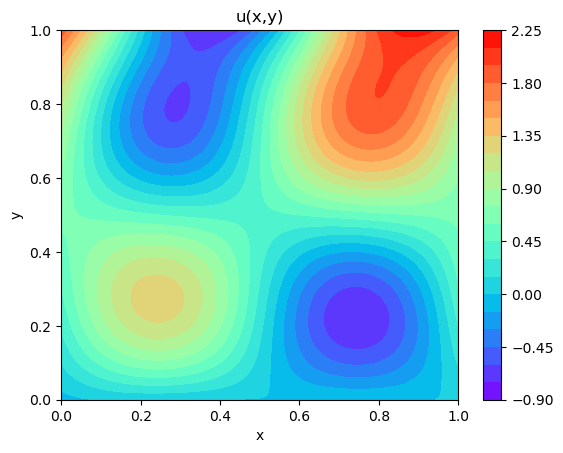

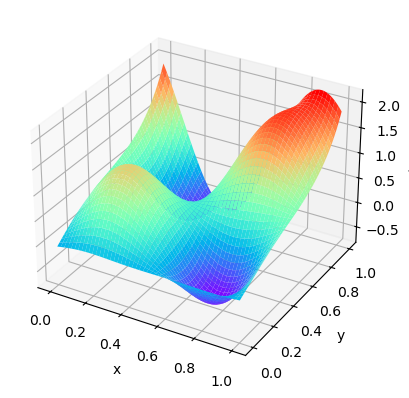

In [65]:
u_pred = model.forward(x_test[:, 0:1], x_test[:, 1:2]).cpu().detach()
u_pred = u_pred.reshape(total_points_x, total_points_y).transpose(1, 0)

# I think this transpose is correct? The shapes are weird
plot3D_Matrix(X, Y, u_pred)

In [66]:
def f_real(x, y):
    return torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)

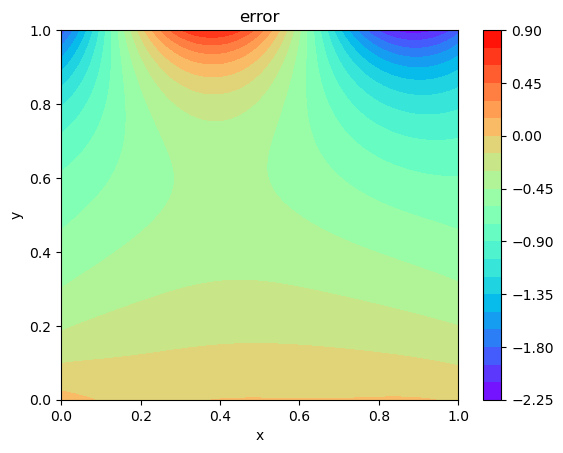

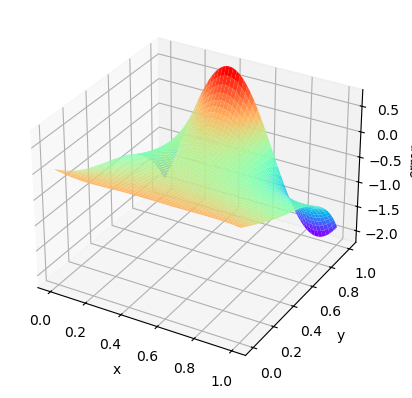

In [67]:
x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)

error = f_real(X, Y) - u_pred

plot3D_error(X, Y, error)

In [68]:
x = torch.linspace(x_min, x_max, total_points_x).to(device)
y = torch.linspace(y_min, y_max, total_points_y).to(device)

X, Y = np.meshgrid(x.cpu(), y.cpu())

S = model.forward(torch.tensor(X.flatten()[:, None]).to(device), torch.tensor(Y.flatten()[:, None]).to(device))

[0, 49, 99, 149, 199]


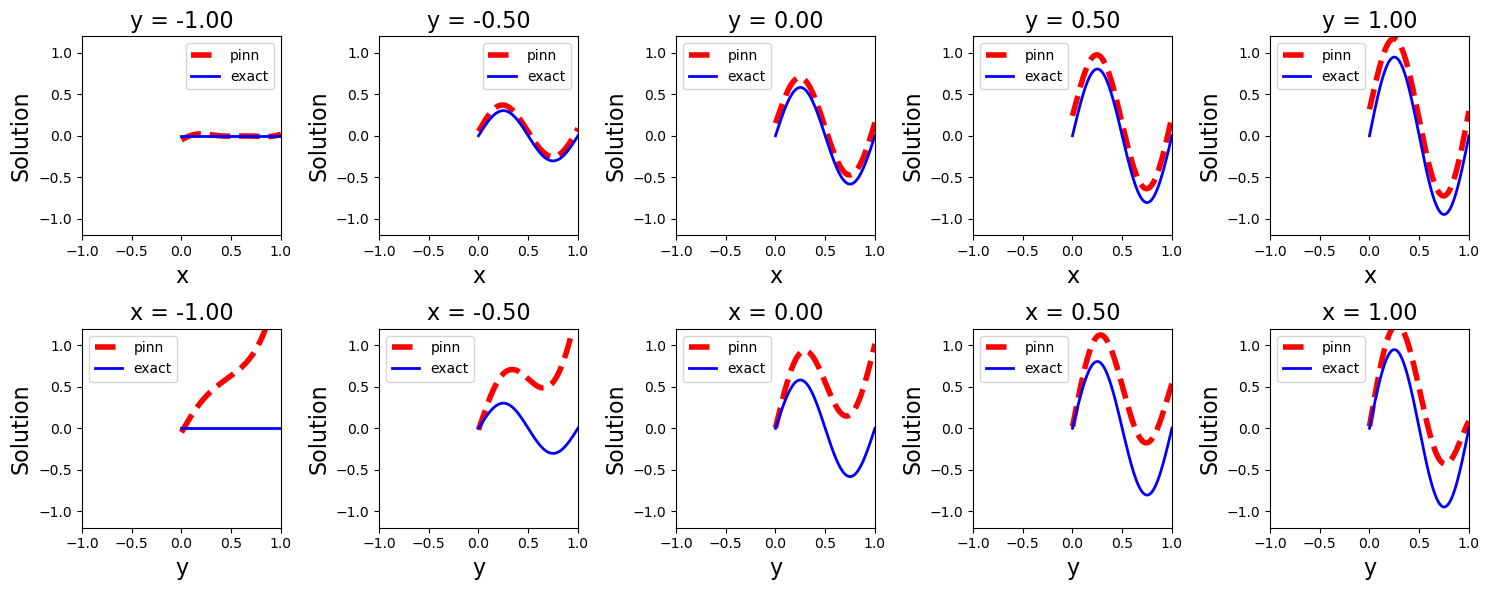

In [69]:
S_ = S.reshape(total_points_x, total_points_y)
T_ = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

height = 3
frames_val = np.array([-1., -0.5, 0., 0.5, 1.])
frames = [*map(int, (frames_val + 1)/2 * (200-1))]
fig = plt.figure("", figsize=(len(frames)*height, 2*height))

print(frames)

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X[var_index, :], S_[var_index,:].cpu().detach().numpy(), "r--", lw=4., label="pinn")
    plt.plot(X[var_index, :], T_[var_index,:], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("x",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y[:, var_index], S_[:,var_index].cpu().detach().numpy(), "r--", lw=4., label="pinn")
    plt.plot(Y[:, var_index], T_[:,var_index], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("y",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

#plt.savefig("profiles.png")
plt.show()